In [1]:
import pandas as pd
import numpy as np
import scanpy as sc

sc.settings.verbosity = 1
sc.settings.set_figure_params(dpi=150, color_map='viridis')
sc.logging.print_versions()

num_top_genes = 90

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.8.0
sinfo       0.3.4
-----
PIL                 8.2.0
appnope             0.1.2
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cached_property     1.5.2
cffi                1.14.5
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
h5py                3.2.1
igraph              0.9.6
ipykernel           5.3.4
ipython_genutils    0.2.0
jedi                0.17.0
joblib              1.0.1
kiwisolver   

In [2]:
path = "chen_counts.txt"
adata = sc.read_text(path).T
adata

AnnData object with n_obs × n_vars = 14437 × 23284

In [3]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=5)
adata.obs['n_counts'] = adata.X.sum(axis=1)

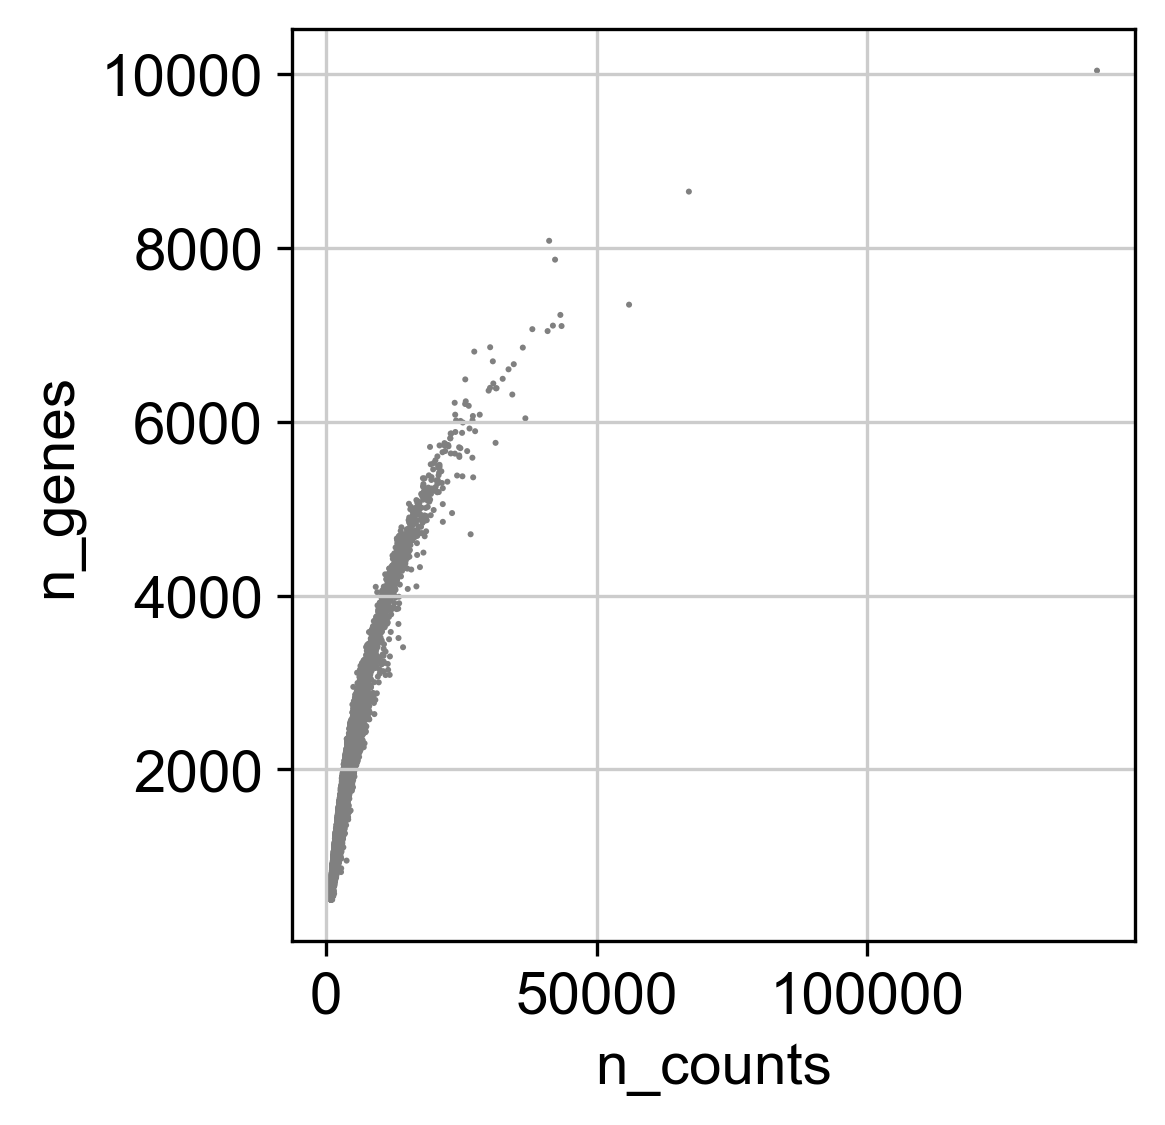

In [4]:
sc.pl.scatter(adata, x="n_counts", y='n_genes')

In [5]:
adata = adata[adata.obs['n_genes'] < 6000, :]
adata = adata[adata.obs['n_counts'] < 20000, :]
adata.raw = sc.pp.log1p(adata, copy=True)

In [6]:
sc.pp.normalize_per_cell(adata)

In [7]:
# df = pd.DataFrame(adata.X)
# df.columns = adata.var.index
# df.to_csv("chen_nonNorm_counts_all.txt", sep="\t")

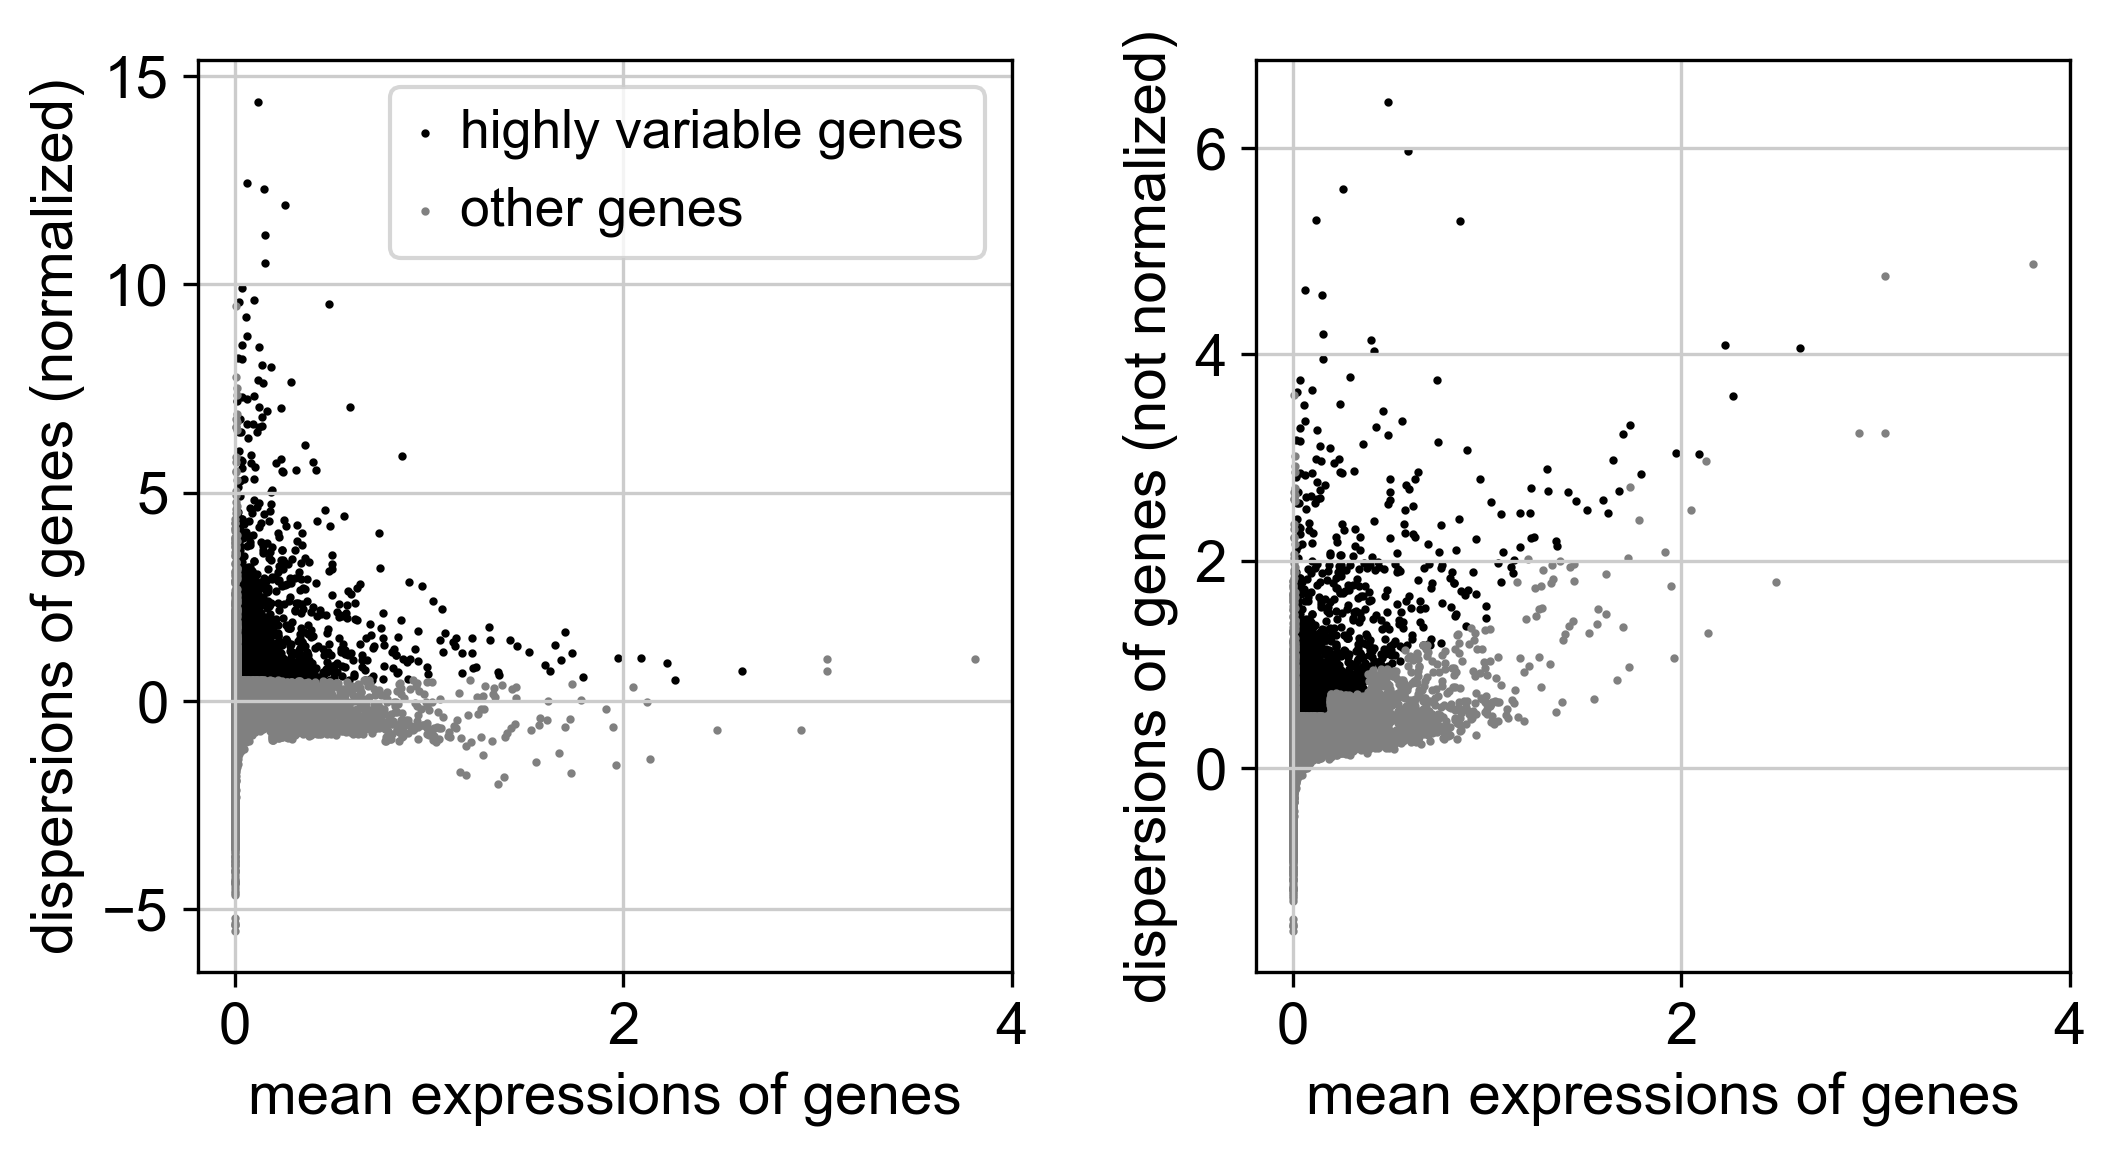

In [8]:
filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [9]:
adata = adata[:, filter_result.gene_subset]
sc.pp.normalize_per_cell(adata)
adata.X_noscale = adata.X #save non-scaled data
sc.pp.log1p(adata)
sc.pp.regress_out(adata, ['n_counts'])
sc.pp.scale(adata)

Trying to set attribute `.obs` of view, copying.


In [10]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [11]:
sc.tl.louvain(adata, resolution=0.3)

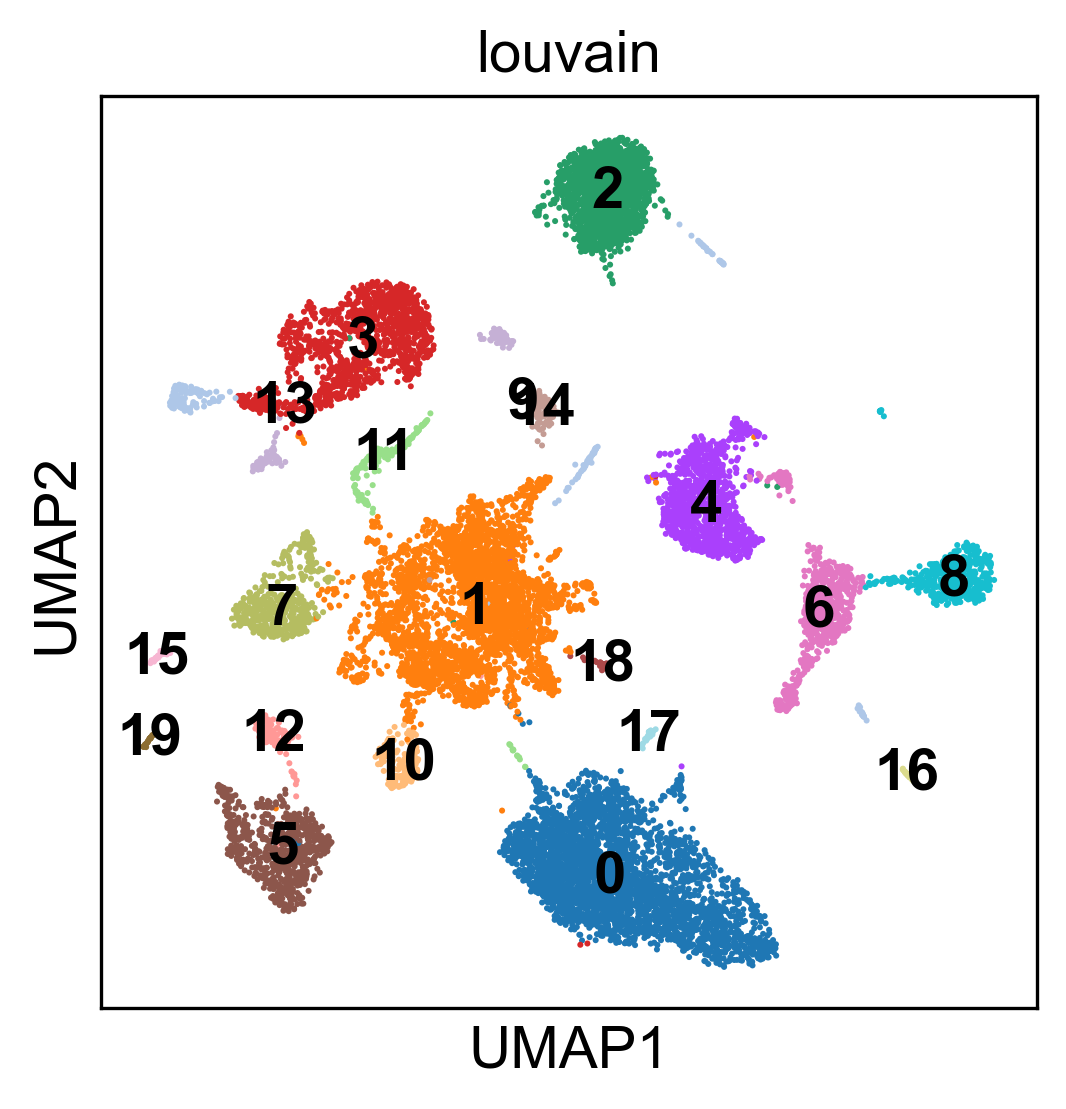

In [12]:
sc.pl.umap(adata, color='louvain',  legend_loc='on data')

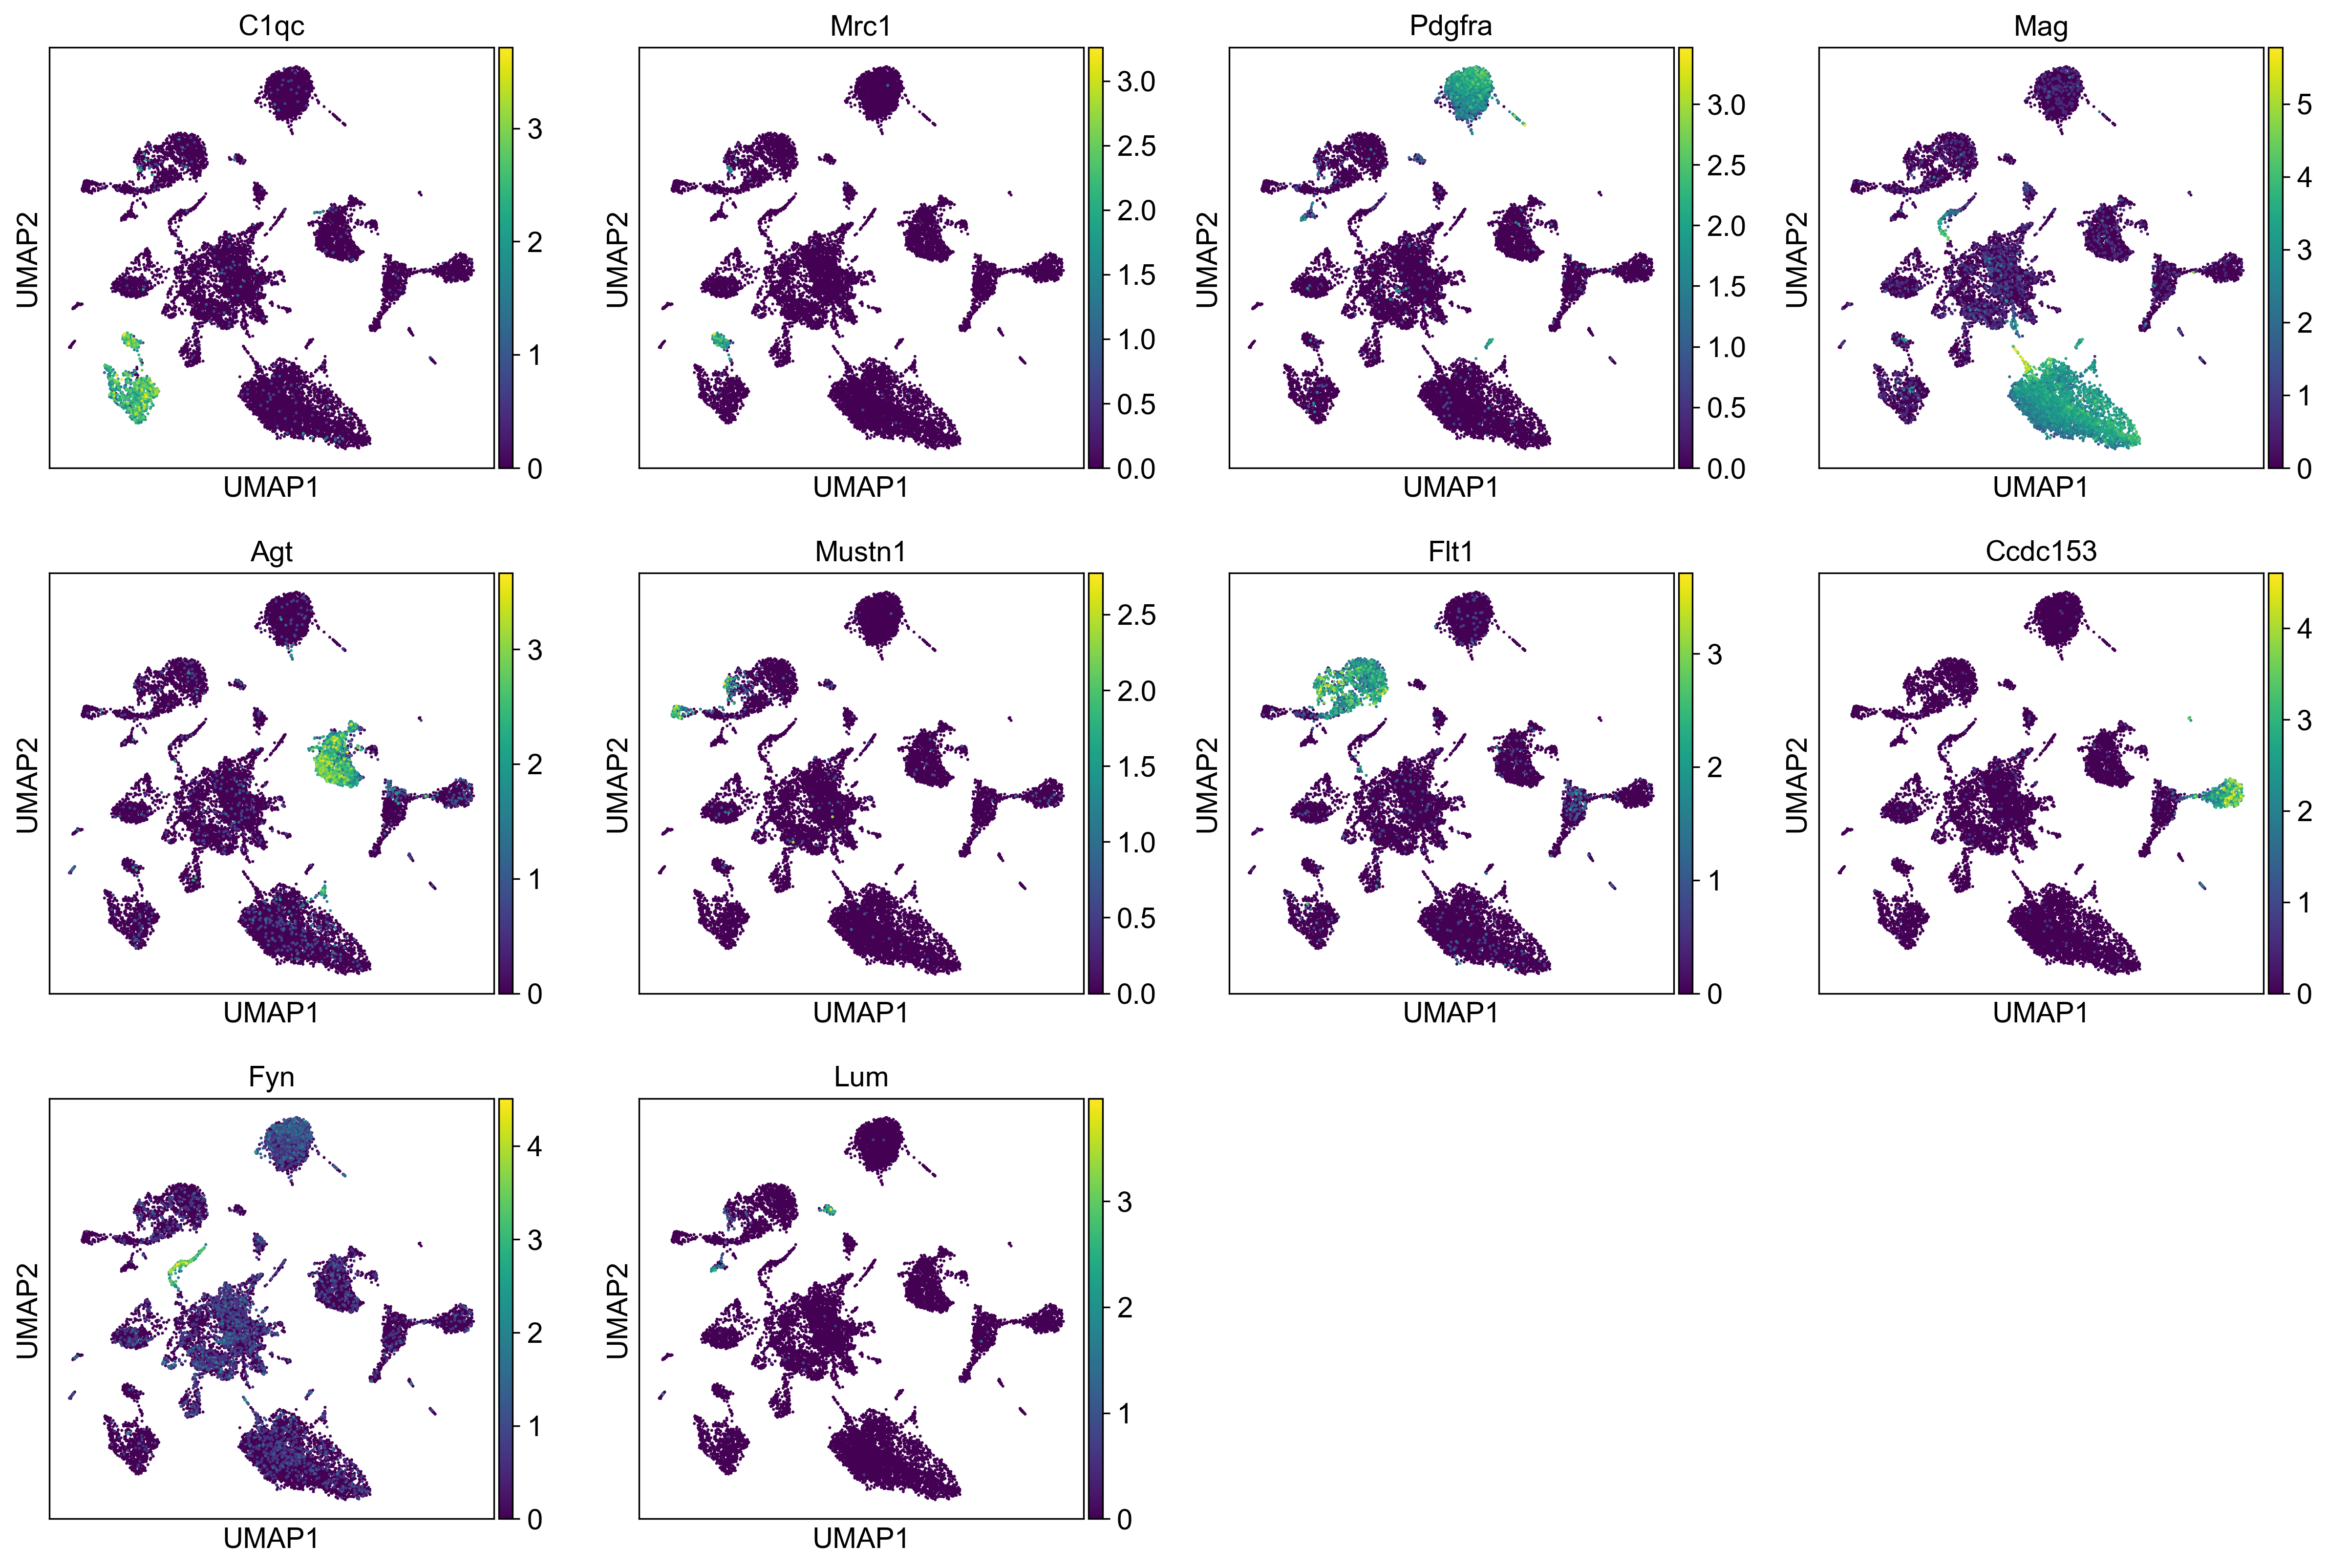

In [13]:
sc.pl.umap(adata, color=['C1qc', 'Mrc1', 'Pdgfra', 'Mag', 'Agt', 'Mustn1', 'Flt1', 'Ccdc153', 'Fyn', 'Lum'])

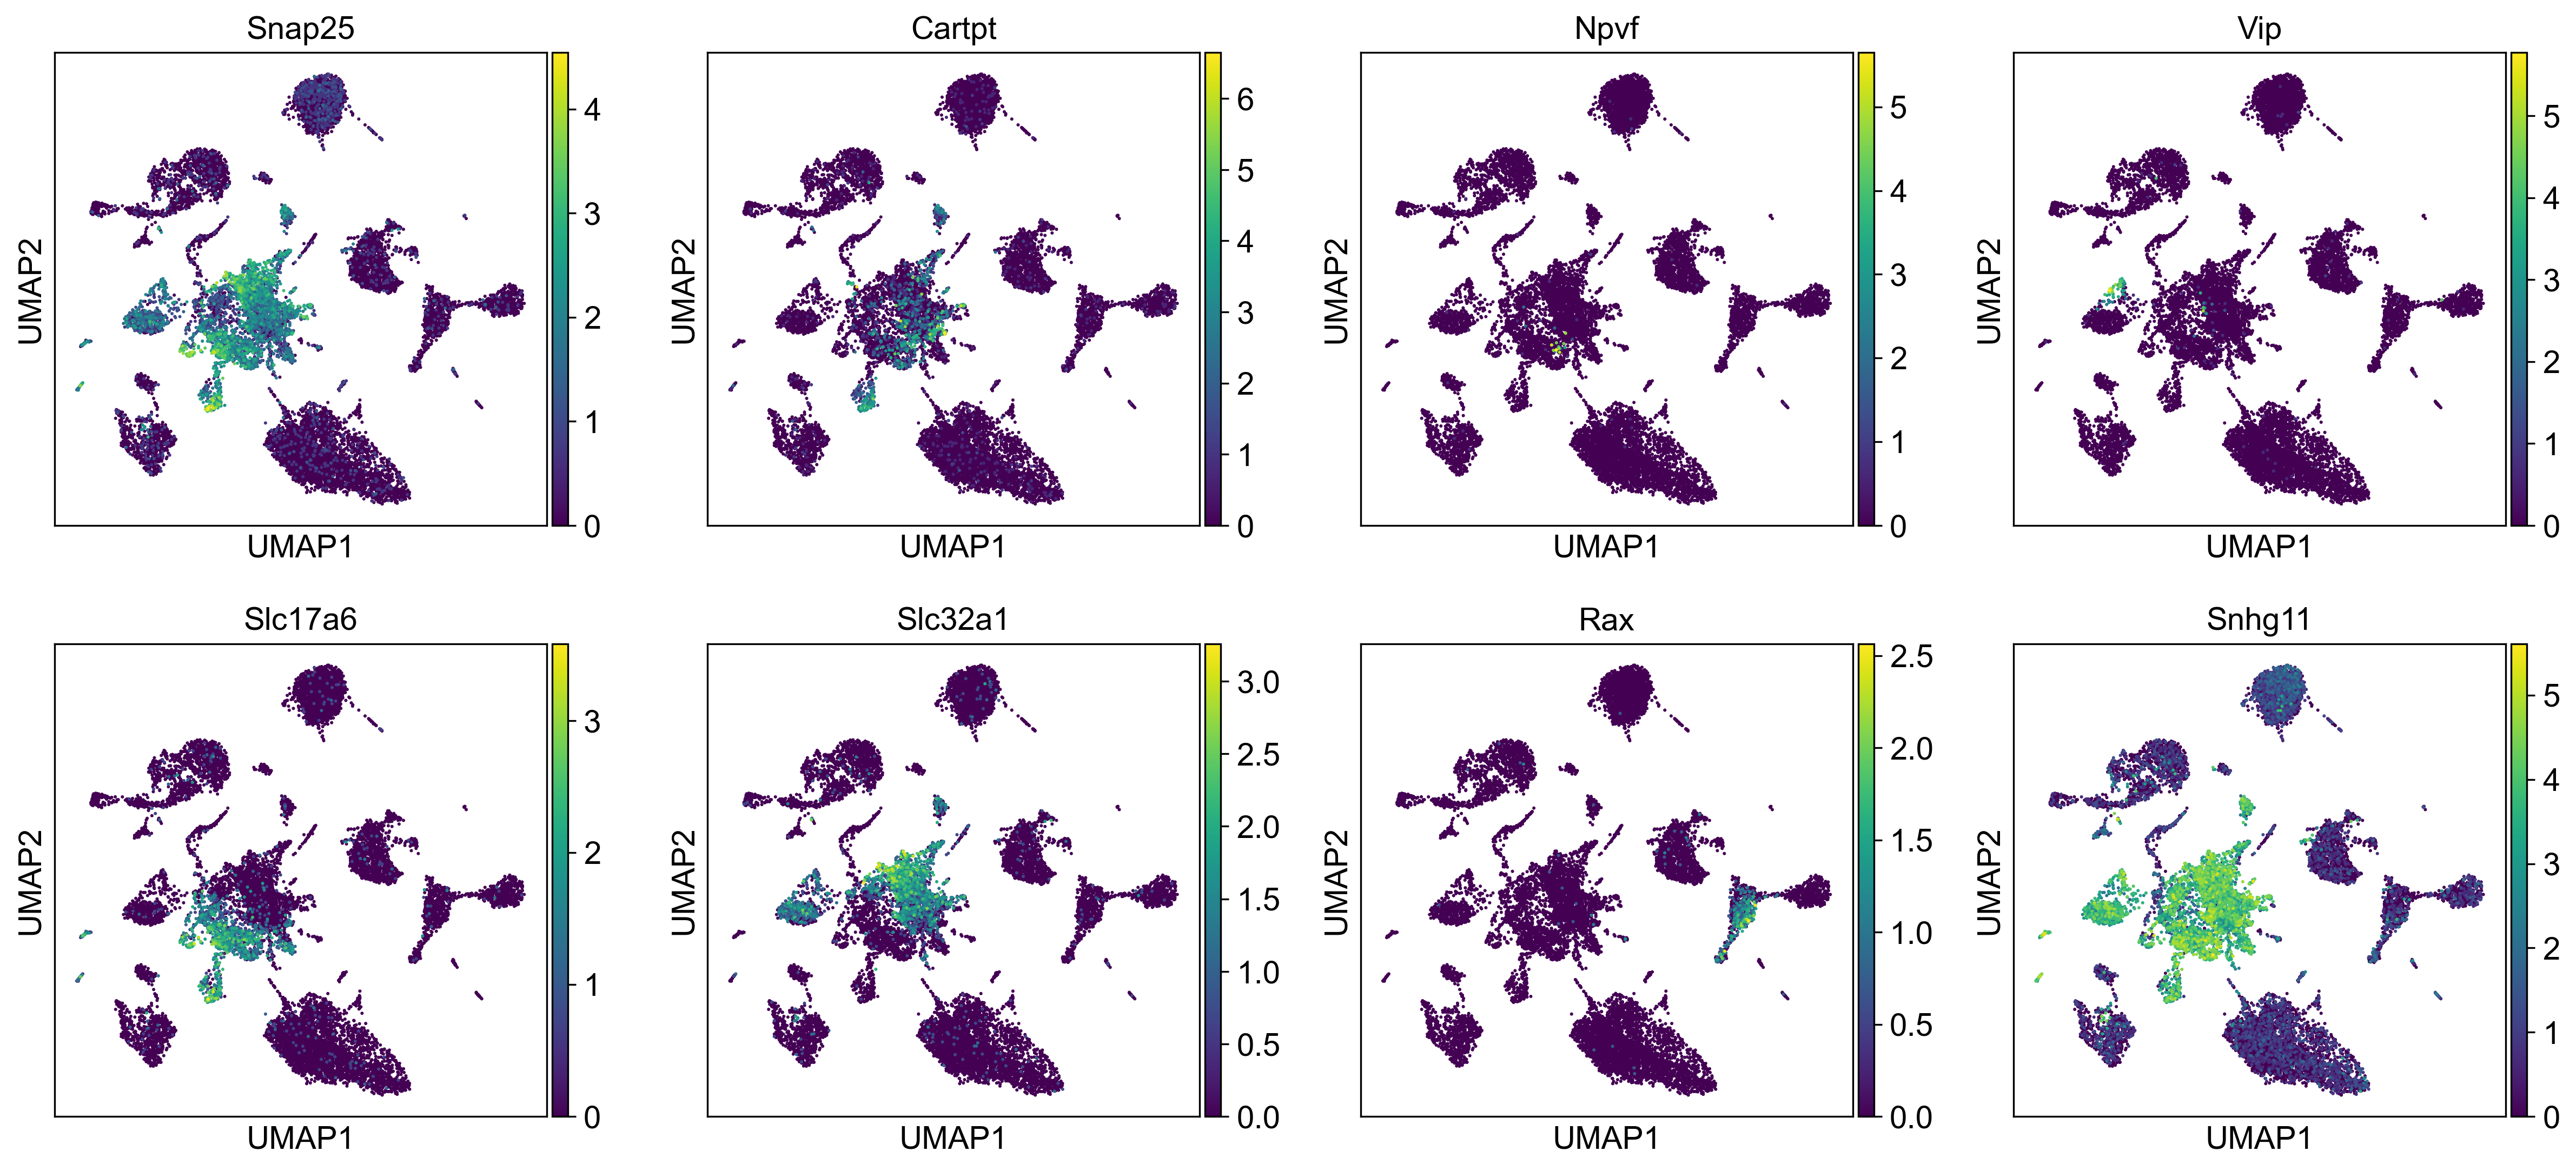

In [14]:
sc.pl.umap(adata, color=['Snap25', 'Cartpt', 'Npvf', 'Vip', 'Slc17a6', 'Slc32a1', 'Rax', 'Snhg11'])

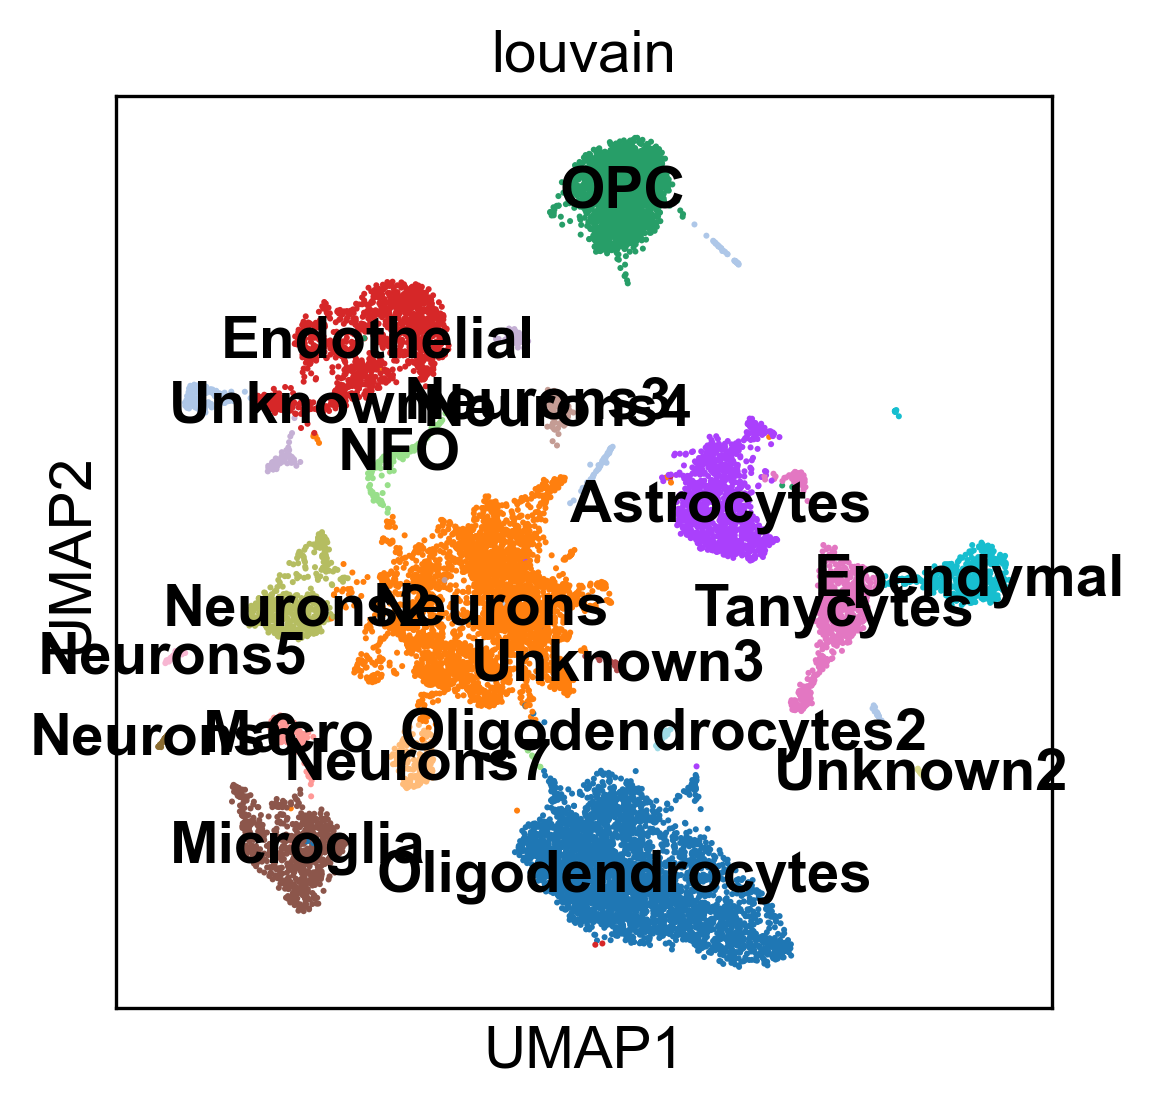

In [15]:
new_celltypes = ['Oligodendrocytes', 'Neurons', 'OPC', 'Endothelial', 'Astrocytes','Microglia', 'Tanycytes',
                 'Neurons2', 'Ependymal','Neurons3', 'Neurons7','NFO','Macro','Unknown', 'Neurons4', 'Neurons5',
                 'Unknown2','Oligodendrocytes2','Unknown3','Neurons6']
adata.rename_categories('louvain', new_celltypes)
sc.pl.umap(adata, color='louvain', legend_loc='on data')

In [16]:
celltypes = pd.DataFrame(adata.obs['louvain'])
celltypes.louvain.replace(['Unknown2', 'Unknown3'], ['Unknown', 'Unknown'], inplace=True)
celltypes.louvain.replace(['Neurons2', 'Neurons3', 'Neurons4', 'Neurons5', 'Neurons6', 'Neurons7'],
                         ['Neurons', 'Neurons', 'Neurons', 'Neurons', 'Neurons', 'Neurons'], inplace=True)
celltypes.louvain.replace(['Macro', 'Oligodendrocytes2'],
                          ['Microglia', 'Oligodendrocytes'], inplace=True)
adata.obs['celltype'] = celltypes.louvain

... storing 'celltype' as categorical


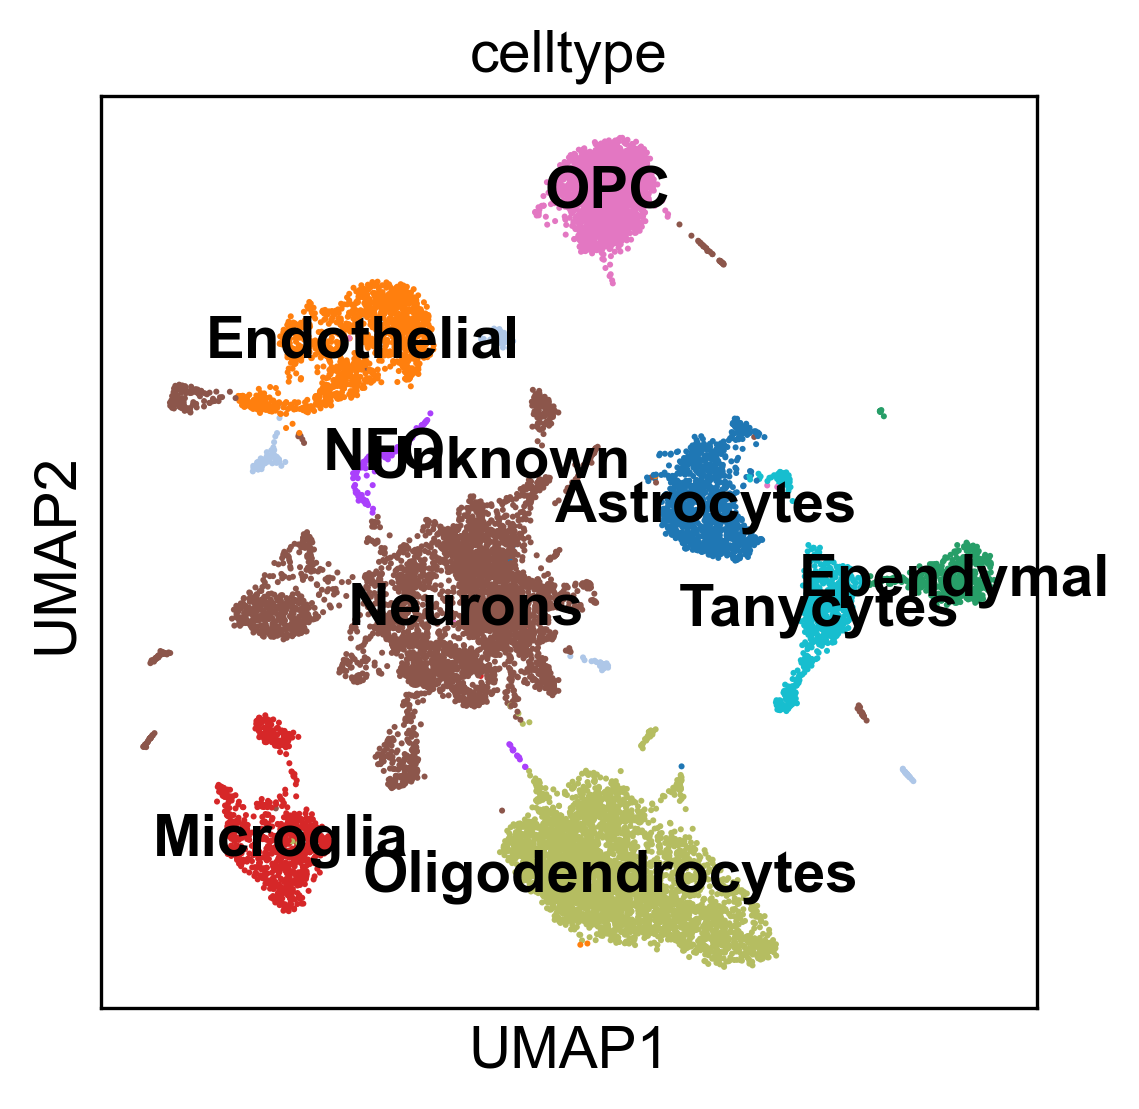

In [17]:
sc.pl.umap(adata, color='celltype', legend_loc='on data')

In [18]:
celltypes = pd.DataFrame(adata.obs['celltype'])
celltypes.columns = ['Celltype']
celltypes.to_csv("chen_celltypes.txt", sep="\t")